In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
# CHANNELS=3
EPOCHS=50

In [13]:
dataset=tf.keras.utils.image_dataset_from_directory(
"PlantVillage",
image_size=(IMAGE_SIZE, IMAGE_SIZE),
shuffle=True,
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2023-12-26 19:16:16.636150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
class_names=dataset.class_names

In [15]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset)

68

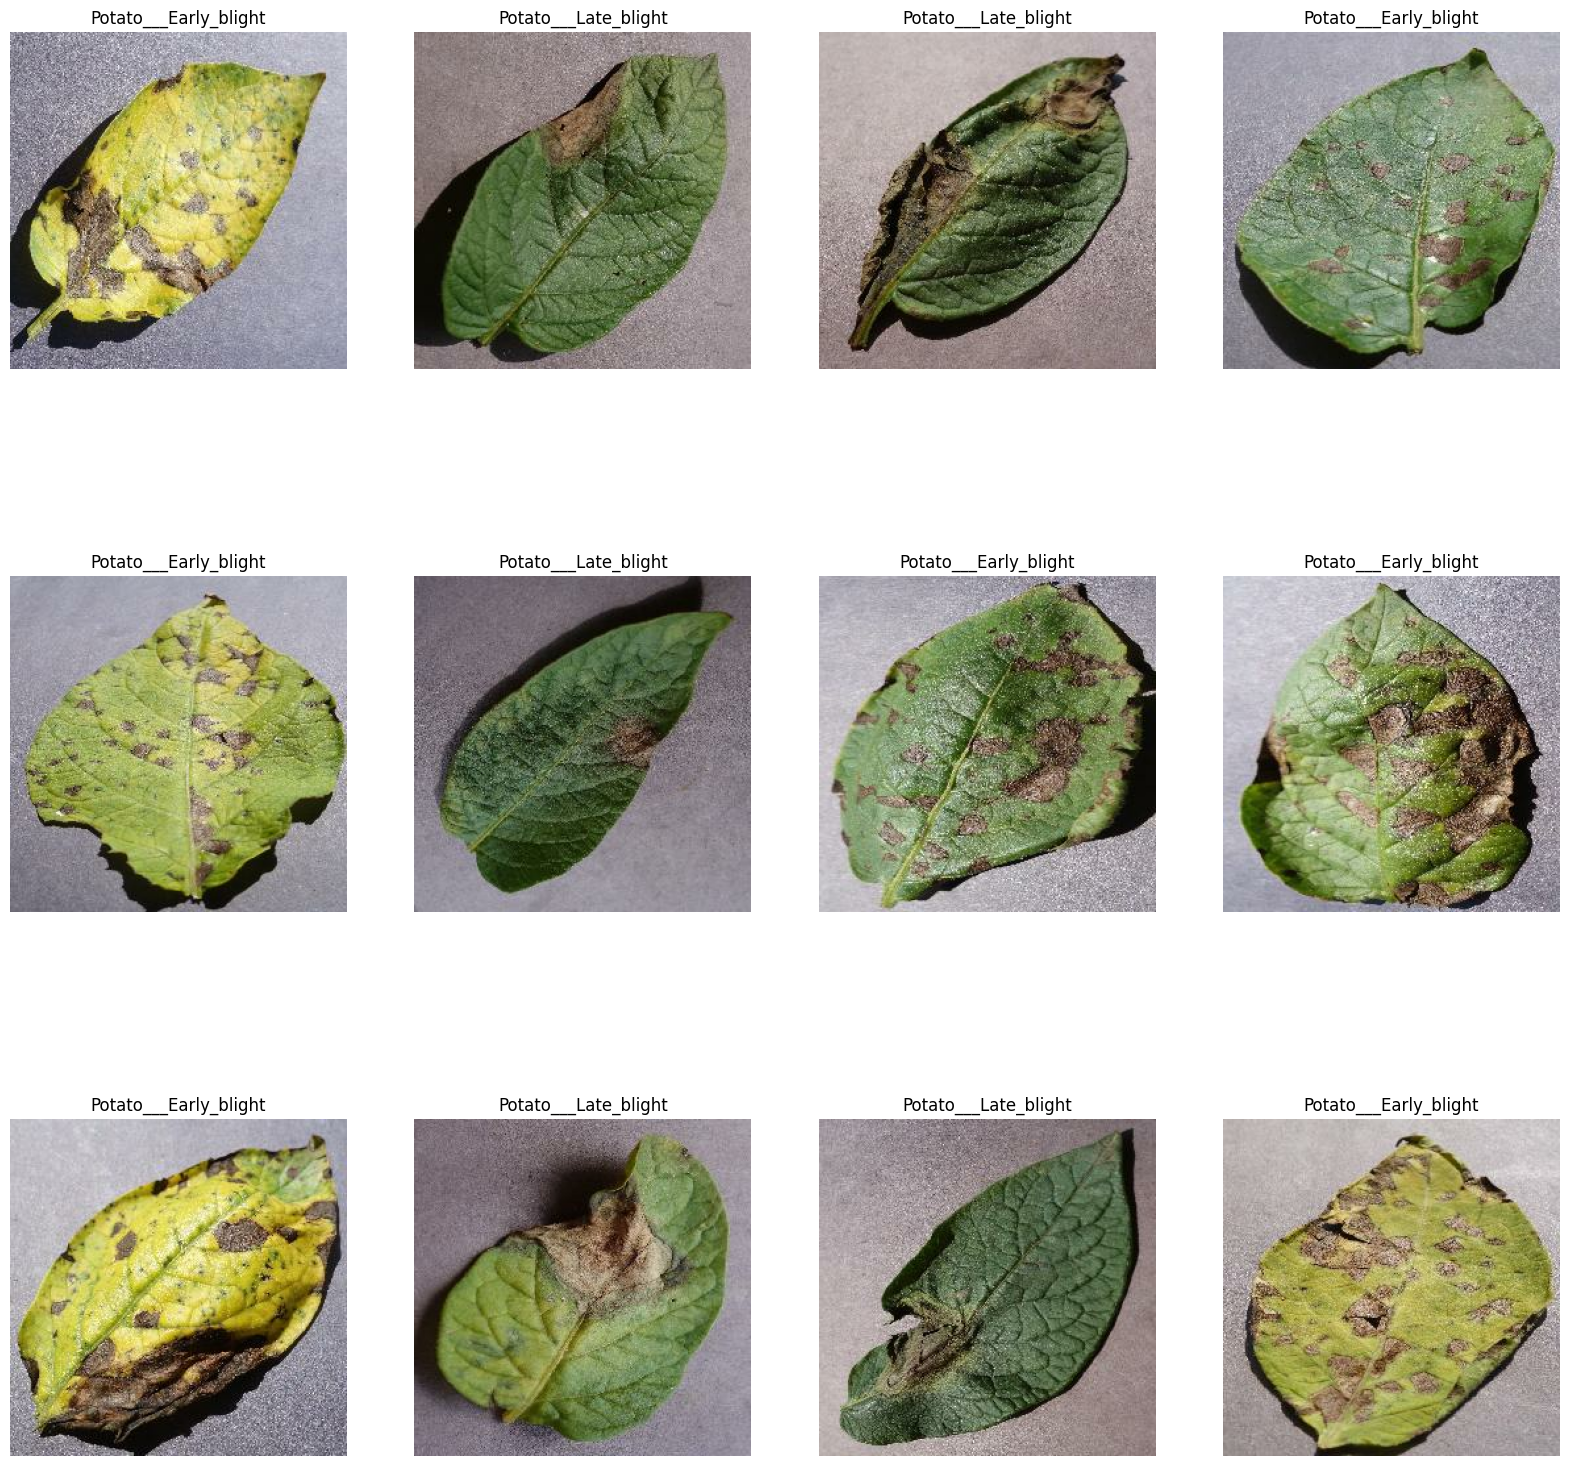

In [17]:
plt.figure(figsize=(20,20))
for image_batch,label_batch  in dataset.take(1):
        for i in range(12):
            plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")
    
   

In [18]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [19]:
train_ds=dataset.take(54)
len(train_ds)

54

In [20]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [21]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [23]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [46]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [64]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 4), activation='relu')),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [66]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)        

In [67]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30


/home/daltonbigirimana/anaconda3/envs/testenv/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-26 19:29:52.597260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41 of 10000
2023-12-26 19:29:56.838033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-12-26 19:29:56.838097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-26 19:29:56.853187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-12-26 19:29:57.532055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-

 1/54 [..............................] - ETA: 49:53 - loss: 1.1009 - accuracy: 0.1875

2023-12-26 19:30:42.149496: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2023-12-26 19:30:43.684309: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


 2/54 [>.............................] - ETA: 9:51 - loss: 1.0870 - accuracy: 0.3125 

2023-12-26 19:30:48.588140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


54/54 [==============================] - ETA: 0s - loss: 0.8596 - accuracy: 0.5249

2023-12-26 19:34:31.180235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 12 of 10000
2023-12-26 19:34:41.031724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 48 of 10000
2023-12-26 19:34:45.642078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-12-26 19:34:45.642456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-26 19:34:45.642528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2 of 1000
2023-12-26 19:34:45.642676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-12-26 19:34:45.642785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-26 19:34:45.642846: I tensorflow/co

54/54 [==============================] - 314s 5s/step - loss: 0.8596 - accuracy: 0.5249 - val_loss: 0.7377 - val_accuracy: 0.6302
Epoch 2/30
54/54 [==============================] - 170s 3s/step - loss: 0.6674 - accuracy: 0.6950 - val_loss: 0.5639 - val_accuracy: 0.7500
Epoch 3/30
38/54 [====================>.........] - ETA: 47s - loss: 0.4685 - accuracy: 0.7878

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [61]:
history

BATCH_SIZE = 32
IMAGE_SIZE = 256
# CHANNELS=3
EPOCHS=50
dataset=tf.keras.utils.image_dataset_from_directory(
"PlantVillage",
image_size=(IMAGE_SIZE, IMAGE_SIZE),
shuffle=True,
batch_size=BATCH_SIZE
)
class_names=dataset.class_names
BATCH_SIZE = 32
IMAGE_SIZE = 256
# CHANNELS=3
EPOCHS=50
dataset=tf.keras.utils.image_dataset_from_directory(
"PlantVillage",
image_size=(IMAGE_SIZE, IMAGE_SIZE),
shuffle=True,
batch_size=BATCH_SIZE
)
class_names=dataset.class_names
class_names
len(dataset)
plt.figure(figsize=(20,20))
for image_batch,label_batch  in dataset.take(1):
        for i in range(12):
            plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")
train_size=0.8
len(dataset)*train_size
import tensorflow as tf
from tensorflow.keras import  models,layers
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMAGE_SIZE = 256
# CHANNELS=3
EPOCHS=50
dataset=tf.keras.utils.image_dataset

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
history.history['loss']
type(history.history['loss'])

In [170]:
len(history.history['loss'])

NameError: name 'history' is not defined

In [171]:
history.history['loss'][:5] # show loss for first 5 epochs

NameError: name 'history' is not defined

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

NameError: name 'acc' is not defined

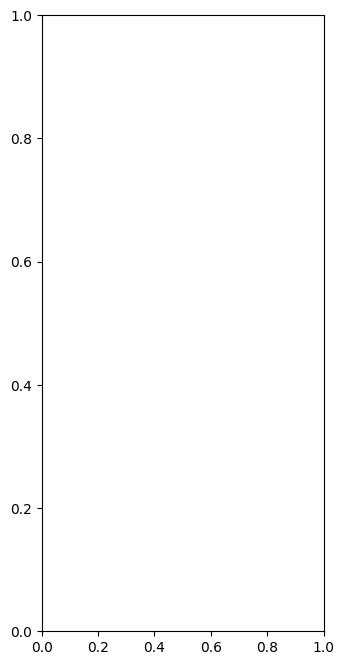

In [173]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [174]:
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[7].numpy().astype('uint8')
    first_label = labels_batch[7].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

2023-12-26 13:12:20.762989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 23 of 10000
2023-12-26 13:12:30.697759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42 of 10000
2023-12-26 13:12:40.910666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 56 of 10000
2023-12-26 13:12:44.450376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-12-26 13:12:47.275234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-12-26 13:12:47.636570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2 of 1000
2023-12-26 13:12:47.636622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 3 of 1000
202

first image to predict
actual label: Potato___Late_blight


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("../potatoes.h5")
model.save('saved_model/10')